In [17]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import matplotlib.pyplot as plt


N_SAMPLES = 1000

In [19]:
def generate_polynomial_dataset(degree: int, n_samples: int):
    x_set = []
    y_set = []
    for i in range(n_samples):
        x = np.random.uniform(-5, 5)
        y = sum(np.random.uniform(0, 1) * (x ** i) for i in range(degree+1)) + np.random.normal(0, 1)
        x_set.append(x)
        y_set.append(y)
    return np.array(x_set), np.array(y_set)

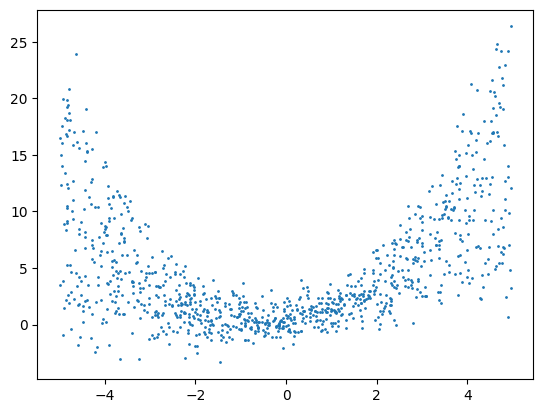

In [20]:
np.random.seed(0)
x, y = generate_polynomial_dataset(2, 1000)
x,y
plt.scatter(x, y, s=1)

In [21]:
class ClosedFormRidgeRegressor:
    def __init__(self, alpha: float):
        self.alpha = alpha
        self.w = None

    def fit(self, x, y):
        x = np.column_stack((np.ones(x.shape), x))
        # add bias term
        I = np.identity(x.shape[1])
        # bias trick
        I[0, 0] = 0
        #closed form solution
        self.w = np.linalg.inv(x.T @ x + self.alpha * I) @ x.T @ y
        
    def predict(self, x):
        x = np.column_stack((np.ones(x.shape), x))
        return x @ self.w

In [22]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
test_alphas = [0, 0.1, 1, 100, 1000, 5000,1000000]

In [23]:
# linear regression
np.random.seed(0)
linear_dataset = generate_polynomial_dataset(1, 1000)
xlin, ylin = linear_dataset
x_train, x_test, y_train, y_test = train_test_split(xlin, ylin, test_size=0.2, random_state=42)
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

Alpha: 0
SGD Coefficients: [0.46384234]
SGD Intercept: [0.51078601]
Closed Form Coefficients: [0.47808874]
Closed Form Intercept: 0.49801504331852875


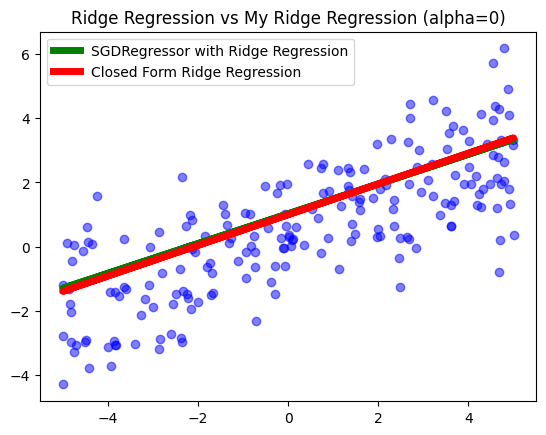

Alpha: 0.1
SGD Coefficients: [0.45821726]
SGD Intercept: [0.49645558]
Closed Form Coefficients: [0.47808208]
Closed Form Intercept: 0.49801478029821056


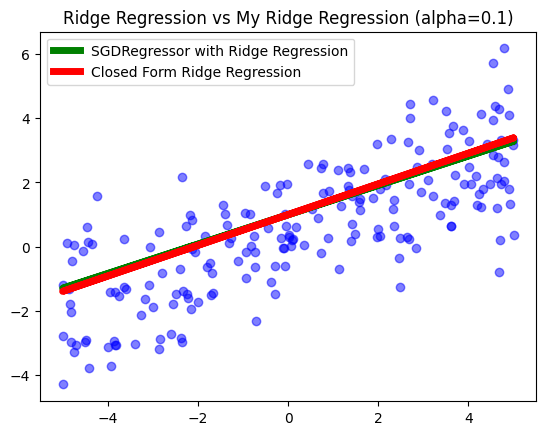

Alpha: 1
SGD Coefficients: [0.37468744]
SGD Intercept: [0.49969888]
Closed Form Coefficients: [0.47802219]
Closed Form Intercept: 0.4980124134448569


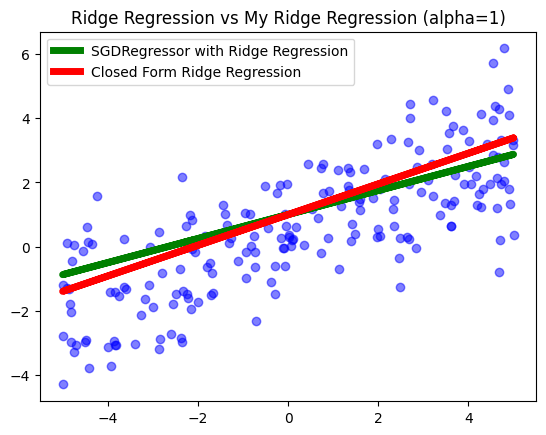

Alpha: 100
SGD Coefficients: [0.03621915]
SGD Intercept: [0.46596365]
Closed Form Coefficients: [0.47152423]
Closed Form Intercept: 0.49775563084948604


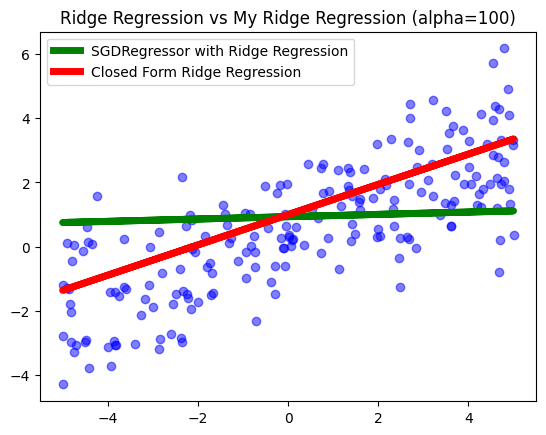

Alpha: 1000
SGD Coefficients: [-5.05298385e-05]
SGD Intercept: [0.47469106]
Closed Form Coefficients: [0.41966364]
Closed Form Intercept: 0.49570623341200304


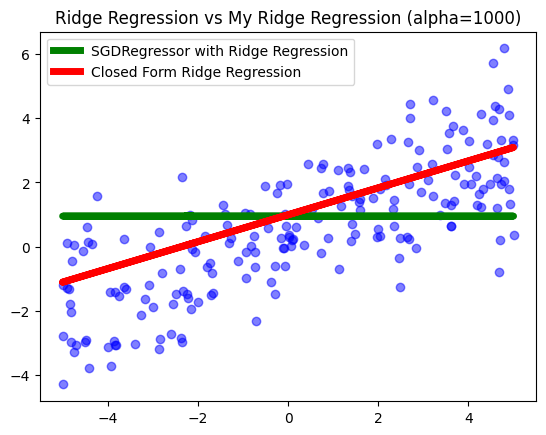

Alpha: 5000
SGD Coefficients: [0.00877267]
SGD Intercept: [0.477702]
Closed Form Coefficients: [0.28187627]
Closed Form Intercept: 0.49026122984884546


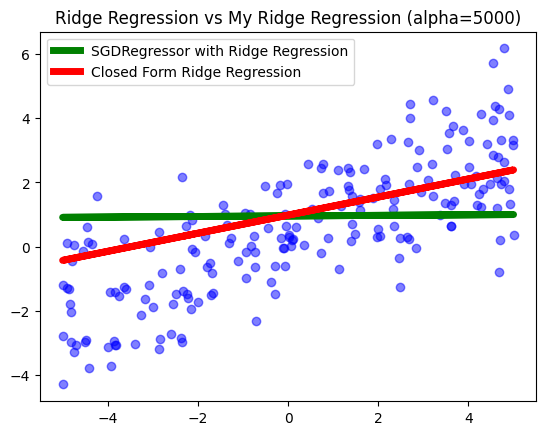

Alpha: 1000000
SGD Coefficients: [-0.00031456]
SGD Intercept: [0.45739902]
Closed Form Coefficients: [0.00340959]
Closed Form Intercept: 0.47925694103701477


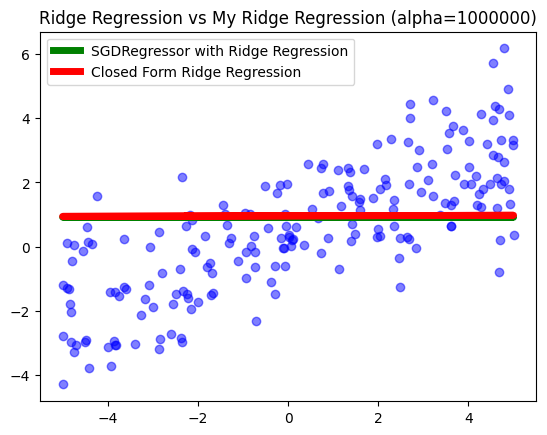

In [24]:
# Linear dataset testing
for alpha in test_alphas:
    ridge = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000)
    ridge.fit(x_train, y_train)
    
    print(f"Alpha: {alpha}")
    print(f"SGD Coefficients: {ridge.coef_}")
    print(f"SGD Intercept: {ridge.intercept_}")

    ridge_pred = ridge.predict(x_test)
    ridge_pred = ridge_pred + ridge.intercept_

    my_ridge = ClosedFormRidgeRegressor(alpha=alpha)
    my_ridge.fit(x_train, y_train)
    print(f"Closed Form Coefficients: {my_ridge.w[1:]}")
    print(f"Closed Form Intercept: {my_ridge.w[0]}")
    my_ridge_pred = my_ridge.predict(x_test)
    # add intercep to the prediction
    my_ridge_pred = my_ridge_pred + my_ridge.w[0]


    plt.plot(x_test, ridge_pred, label='SGDRegressor with Ridge Regression',color='green', linewidth=5)
    plt.plot(x_test, my_ridge_pred, label='Closed Form Ridge Regression', color='red', linewidth=5)
    plt.scatter(x_test, y_test, color='blue', alpha=0.5)
    plt.title(f"Ridge Regression vs My Ridge Regression (alpha={alpha})")
    plt.legend()
    plt.show()

Closed Form Coefficients: [5.06087987e-12 4.50167707e-01 4.99941766e-01]


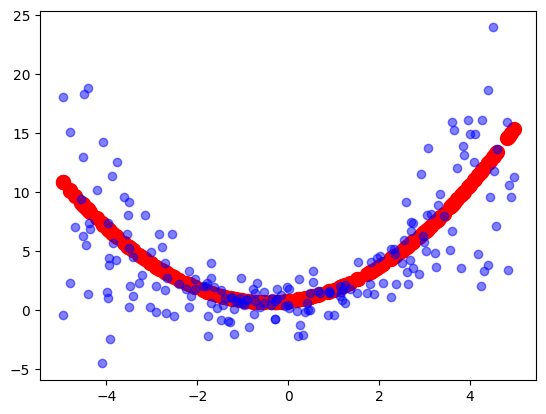

In [25]:
# Quadratic dataset testing
xquad, yquad = generate_polynomial_dataset(2,1000)
x_train, x_test, y_train, y_test = train_test_split(xquad, yquad, test_size=0.2, random_state=42)

x_train_poly = np.column_stack((x_train, x_train**2))
x_test_poly = np.column_stack((x_test, x_test**2))

# Quadratic dataset testing
quad_clf = ClosedFormRidgeRegressor(alpha=0.1)
quad_clf.fit(x_train_poly, y_train)
quad_pred = quad_clf.predict(x_test_poly)
print(f"Closed Form Coefficients: {quad_clf.w[1:]}")
quad_pred = quad_pred + quad_clf.w[0]

plt.scatter(x_test, quad_pred, label='Closed Form Ridge Regression', color='red', linewidth=5)
plt.scatter(x_test, y_test, color='blue', alpha=0.5)

Closed Form Coefficients: [1.54625385e-11 1.54625385e-11 7.15809157e-01 5.76864225e-01
 4.78551267e-01]


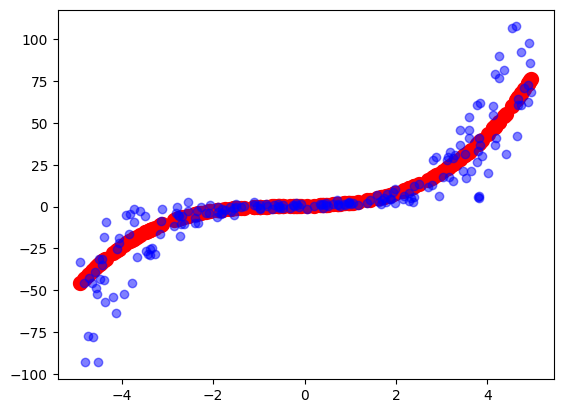

In [26]:
# Cubic dataset testing
x_cubic, y_cubic = generate_polynomial_dataset(3,1000)
x_train, x_test, y_train, y_test = train_test_split(x_cubic, y_cubic, test_size=0.2, random_state=42)

x_train_poly = np.column_stack((x_train, x_train**2))
x_test_poly = np.column_stack((x_test, x_test**2))
x_train_poly = np.column_stack((x_train_poly, x_train**3))
x_test_poly = np.column_stack((x_test_poly, x_test**3))

# Quadratic dataset testing
cubic_clf = ClosedFormRidgeRegressor(alpha=0.1)
cubic_clf.fit(x_train_poly, y_train)
cubic_pred = cubic_clf.predict(x_test_poly)
print(f"Closed Form Coefficients: {cubic_clf.w[1:]}")
cubic_pred = cubic_pred + cubic_clf.w[0]

plt.scatter(x_test, cubic_pred, label='Closed Form Ridge Regression', color='red', linewidth=5)
plt.scatter(x_test, y_test, color='blue', alpha=0.5)

SVM


In [ ]:
from sklearn.svm import SVC
import pandas as pd


import pandas as pd
data = pd.read_csv('wdbc.data', header=None)
data.head()

# Column 0 is an ID, not needed
# Column 1 is the diagnosis, needed
# 3 - 12 are mean
# 13 - 22 are standard error
# 23 - 32 are worst
data.drop(columns=[0], inplace=True)

labels = data.iloc[:, 0].values

mean_data = data.iloc[:, 2:12].values

stde_data = data.iloc[:, 12:22].values

worst_data = data.iloc[:, 22:32].values

mean_data.shape, stde_data.shape, worst_data.shape


array([[1.038e+01, 1.228e+02, 1.001e+03, ..., 2.419e-01, 7.871e-02,
        1.095e+00],
       [1.777e+01, 1.329e+02, 1.326e+03, ..., 1.812e-01, 5.667e-02,
        5.435e-01],
       [2.125e+01, 1.300e+02, 1.203e+03, ..., 2.069e-01, 5.999e-02,
        7.456e-01],
       ...,
       [2.808e+01, 1.083e+02, 8.581e+02, ..., 1.590e-01, 5.648e-02,
        4.564e-01],
       [2.933e+01, 1.401e+02, 1.265e+03, ..., 2.397e-01, 7.016e-02,
        7.260e-01],
       [2.454e+01, 4.792e+01, 1.810e+02, ..., 1.587e-01, 5.884e-02,
        3.857e-01]], shape=(569, 10))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(mean_data, labels, test_size=0.2, random_state=42)
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

SVC(kernel='linear', random_state=42)